In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy


In [153]:
# definitions

def gaussian_2d(x, y, A=1, x0=0, y0=0, sigma=1):
    return A * np.exp(-( (x - x0)**2 / (2 * sigma**2) + (y - y0)**2 / (2 * sigma**2)))

def laplacian_2d(sigma=1):
    #scale = int(12 * sigma)
    #x, y = np.meshgrid(np.linspace(-5, 5, scale), np.linspace(-5, 5, scale))

    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]

    return -(1/(np.pi*sigma**4)) * (1- ((x**2 + y**2) / (2*sigma**2))) * np.exp(-(x**2+y**2)/(2*sigma**2))



In [154]:
def draw_circles(img, blobs, cmap='CMRmap'):
    # the raius is approximate sqrt(2)*sigma

    sigma = 1
    k = np.sqrt(2)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img, cmap=cmap)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r*np.sqrt(2), color='white', linewidth=2, fill=False)
        ax.add_patch(c)

    return fig, ax

In [155]:
def draw_circles_multi(img, coordinates, cmap='CMRmap'):

    fig, ax = plt.subplots(1, len(coordinates), figsize=(20, 20))
    
    for i, coordinate in enumerate(coordinates):        
        ax[i].imshow(img, cmap=cmap)
        for blob in coordinate:
            y, x, r = blob
            c = plt.Circle((x, y), r*np.sqrt(2), color='red', linewidth=1.2, fill=False)
            ax[i].add_patch(c)


    return fig, ax

In [156]:
# Read image
img = io.imread('../images/flowers.png')

# Convert to grayscale
img_gray = color.rgb2gray(img)

In [157]:
def log_image(img_gray, n_kernels=9):

    """
    :param img: input image HAS TO BE GRAYSCALE (or single channel)    
    :param min_sigma: minimum sigma value
    :param max_sigma: maximum sigma value
    :param steps: number of steps
    :return: log image        
    """

    k = np.sqrt(2)
    sigma = 1

    kernels = []
    log_images = []
    sigma_list = []    

    for i in range(0,n_kernels):
        sigma_curr = sigma * k**i
        sigma_list.append(sigma_curr)
            
        kernel_log = laplacian_2d(sigma=sigma_curr)
        kernels.append(kernel_log)

        log_image = scipy.signal.convolve2d(img_gray, kernel_log, mode='same', boundary='symm')
        log_images.append(log_image)
    
    log_images_np = np.array(log_images)

    # plot the kernels
    fig, axs = plt.subplots(1, n_kernels, figsize=(20, 20))
    for i in range(n_kernels):
        axs[i].imshow(kernels[i], cmap='gray')
        axs[i].set_title('sigma: {}' + str(sigma_list[i]))
        axs[i].set_title('sigma: {:.5f}'.format(sigma_list[i]))

    # plot the log images
    fig, axs = plt.subplots(1, n_kernels, figsize=(20, 20))
    for i in range(n_kernels):
        axs[i].imshow(log_images[i], cmap='gray')
        axs[i].set_title(': {:.2f} + {:.2f} {:.2f}'.format(sigma_list[i], max(log_images[i].flatten()), min(log_images[i].flatten())))        

    # threshold the log images
    log_images_thresholded = []
    fig, axs = plt.subplots(1, n_kernels, figsize=(20, 20))
    for i in range(np.shape(log_images_np)[0]):
        log_image_thresholded = np.zeros_like(log_images[i])
        log_image_thresholded[log_images[i] >= max(log_images[i].flatten())-(0.5 * max(log_images[i].flatten()))] = 1
        log_images_thresholded.append(log_image_thresholded)
        axs[i].imshow(log_images_thresholded[i], cmap='gray')
        axs[i].set_title(': {:.2f} + {:.2f} - {:.2f}'.format(sigma_list[i],  max(log_image_thresholded.flatten()), min(log_image_thresholded.flatten())))        


    """
    # plot edges
    fig, axs = plt.subplots(1, n_kernels, figsize=(20, 20))
    for i in range(np.shape(log_images_np)[0]):
        print(min(log_images[i].flatten()), max(log_images[i].flatten()))
        edge = np.zeros_like(log_images[i])
        
        # find elements that are crossing the zero
        edge[log_images[i] >= 0] = 10
        edge[log_images[i] >= 0.2] = 0
        edge[log_images[i] < 0] = 0        

        axs[i].imshow(edge, cmap='gray')
        axs[i].set_title('sigma: {:.5f}'.format(sigma_list[i]))        
    """


    return log_images_np, kernels, np.array(log_images_thresholded), sigma_list

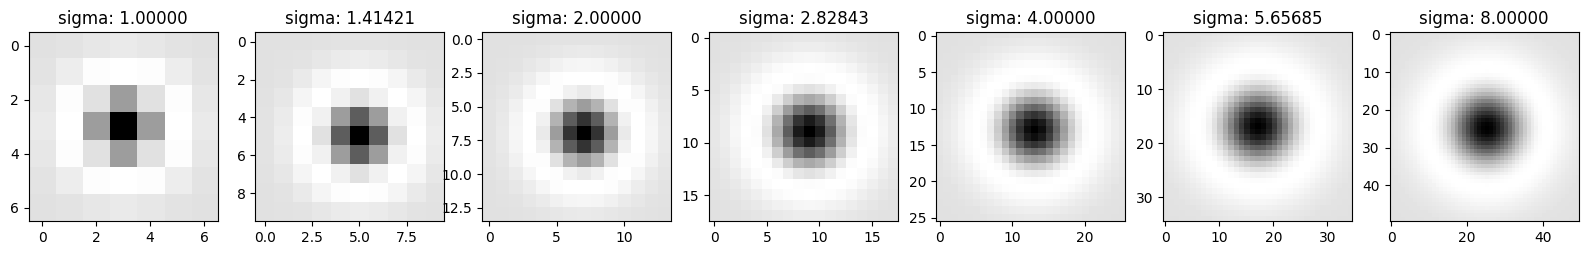

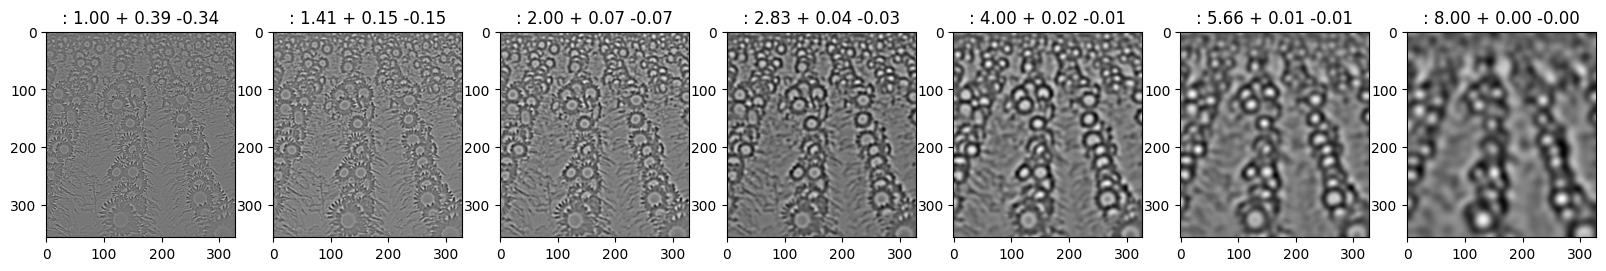

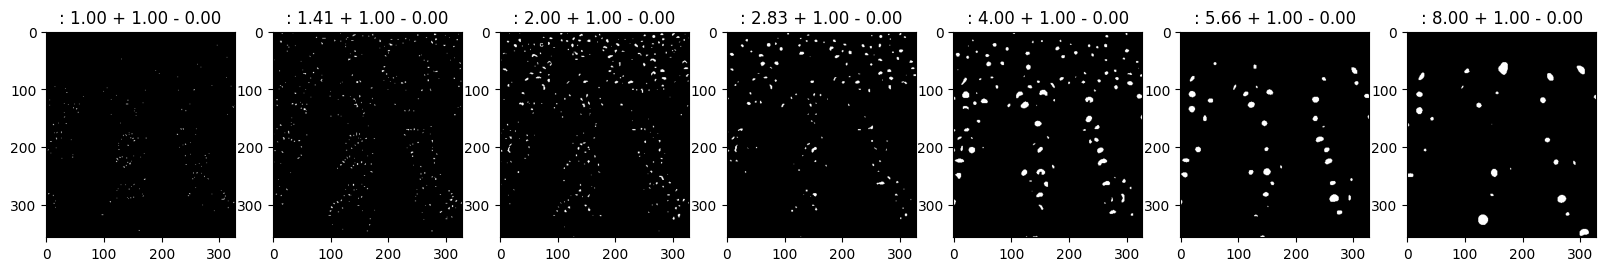

In [158]:
images_log, kernels, log_image_thresholded, sigma_list = log_image(img_gray, 7)

In [ ]:
for x in [0.2, 0.5, 0.7, 0.9]:
    # threshold the log images
    log_images_thresholded = []
    fig, axs = plt.subplots(1, n_kernels, figsize=(20, 20))
    for i in range(np.shape(log_images_np)[0]):
        log_image_thresholded = np.zeros_like(log_images[i])
        log_image_thresholded[log_images[i] >= max(log_images[i].flatten())-(0.5 * max(log_images[i].flatten()))] = 1
        log_images_thresholded.append(log_image_thresholded)
        axs[i].imshow(log_images_thresholded[i], cmap='gray')
        axs[i].set_title(': {:.2f} + {:.2f} - {:.2f}'.format(sigma_list[i],  max(log_image_thresholded.flatten()), min(log_image_thresholded.flatten())))        

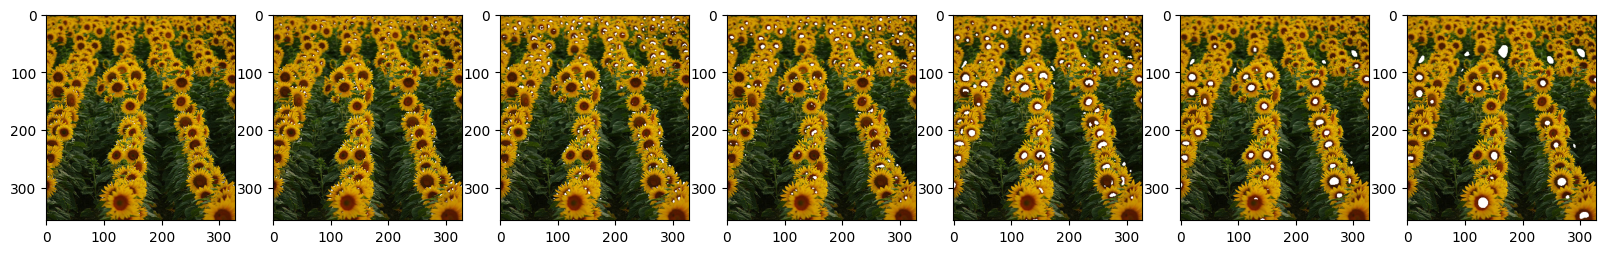

In [131]:
fig, axs = plt.subplots(1, np.shape(log_image_thresholded)[0], figsize=(20, 20))
for i in range(np.shape(log_image_thresholded)[0]):
    img_test = img.copy()
    img_test[log_image_thresholded[i] == 1] = 255
    axs[i].imshow(img_test)



In [132]:
def detect_blob(log_images_np, k = np.sqrt(2), sigma = 1):

    #threshold = 0.33
    co_ordinates = []

    print(log_images_np[0].shape)
    (h,w) = log_images_np[0].shape    

    co_ordinates = [[] for i in range(log_images_np.shape[0])]    

    size = 7

    for i in range(1,h-size, size):
        for j in range(1, w-size, size):
            slice_img = log_images_np[:,i-1:i+size-1,j-1:j+size-1]
            result = np.amax(slice_img) # finding the maximum 
            threshold = max(slice_img.flatten()) - 0.01*max(slice_img.flatten())
            #threshold = max(log_images_np[0].flatten())-(0.5 * max(log_images_np[0].flatten()))
            #threshold = 0.08
            if result > threshold:
                z,x,y = np.unravel_index(np.argmax(slice_img), slice_img.shape)
                co_ordinates[z].append((i+x-1,j+y-1,(k**z)*sigma))       
            
    return co_ordinates

def non_max_suppression(blobs):

    #todo 
    
    pass

In [133]:
def detect_blob_v2(log_images_np, k = np.sqrt(2), sigma = 1, percentage_high = 0.1):
    co_ordinates = []    

    co_ordinates = [[] for i in range(log_images_np.shape[0])]        

    for z in range(log_images_np.shape[0]):

        size = int(np.ceil(sigma * k**z)) * 5        

        padd_y = img.shape[0]%size
        padd_x = img.shape[1]%size        

        list_image = list(log_images_np[z])

        log_image_thresholded_padded = np.pad(list_image, ((0,padd_x),(0,padd_y)), constant_values=0)                

        (h,w) = log_image_thresholded_padded.shape                       
        
        threshold = max(log_images_np[0].flatten())-(percentage_high * max(log_images_np[0].flatten()))

        for i in range(int(size//2),int(h-size//2), size):
            for j in range(int(size//2), int(w-size//2), size):                
                
                slice_img = log_images_np[z,i-size//2:i+size//2,j-size//2:j+size//2]                                
                x_max, y_max = np.unravel_index(np.argmax(slice_img), slice_img.shape)
                
                if slice_img[x_max, y_max] > threshold:
                    co_ordinates[z].append((i+x_max-size//2,j+y_max-size//2,(k**z)*sigma))                         

    return co_ordinates

In [134]:
coordinates = detect_blob_v2(log_image_thresholded)

for i in range(len(coordinates)):
    print(len(coordinates[i]))

120
298
228
153
100
54
25


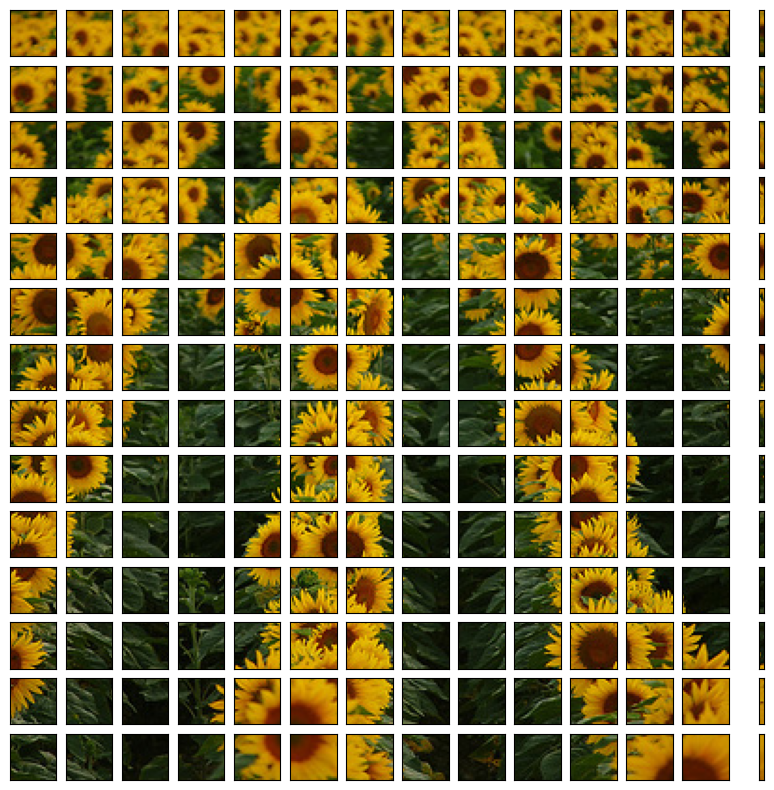

In [135]:
# print image in slices plt

size = 25

fig, axs = plt.subplots(len(img)//size, len(img)//size, figsize=(10, 10))

for i in range(len(img)//size):
    for j in range(len(img)//size):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].imshow(img[i*size:(i+1)*size,j*size:(j+1)*size,:])

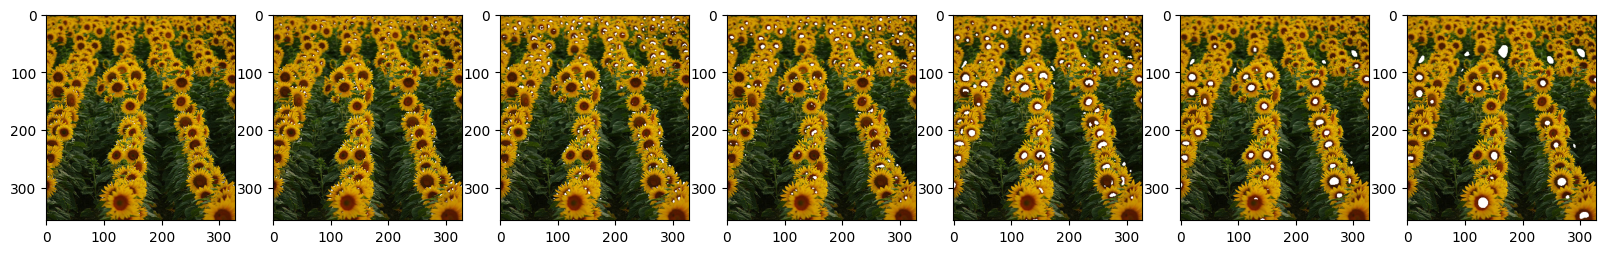

In [136]:
fig, axs = plt.subplots(1, np.shape(log_image_thresholded)[0], figsize=(20, 20))
for i in range(np.shape(log_image_thresholded)[0]):
    img_test = img.copy()
    img_test[log_image_thresholded[i] == 1] = 255
    axs[i].imshow(img_test)

(370, 335, 3)


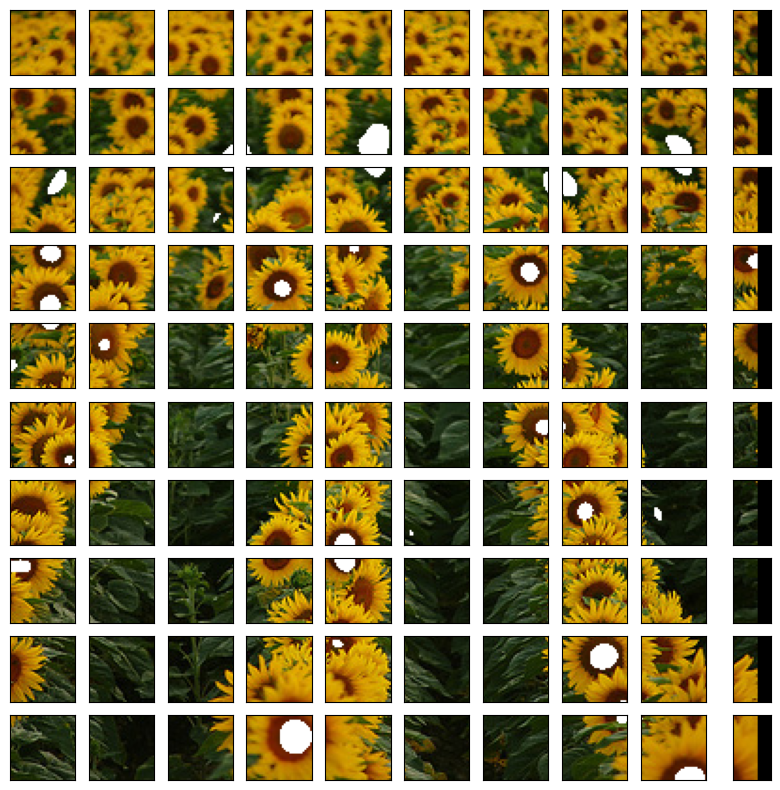

In [145]:

size = 35
padd_x = img.shape[0]%size
padd_y = img.shape[1]%size

img_padded = np.pad(img, ((0,padd_y),(0,padd_x),(0,0)), 'constant', constant_values=0)
log_image_thresholded_padded = np.pad(log_image_thresholded, ((0,0),(0,padd_y),(0,padd_x)), 'constant', constant_values=0)

print(img_padded.shape)
fig, axs = plt.subplots(len(img_padded)//size, len(img_padded)//size, figsize=(10, 10))

for i in range(len(img_padded)//size):
    for j in range(len(img_padded)//size):
        img_test = img_padded.copy()
        img_test[log_image_thresholded_padded[6] == 1] = 255
        #axs[i].imshow(img_test)
        axs[i,j].imshow(img_test[i*size:(i+1)*size,j*size:(j+1)*size,:])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

    

(<Figure size 2000x2000 with 7 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >], dtype=object))

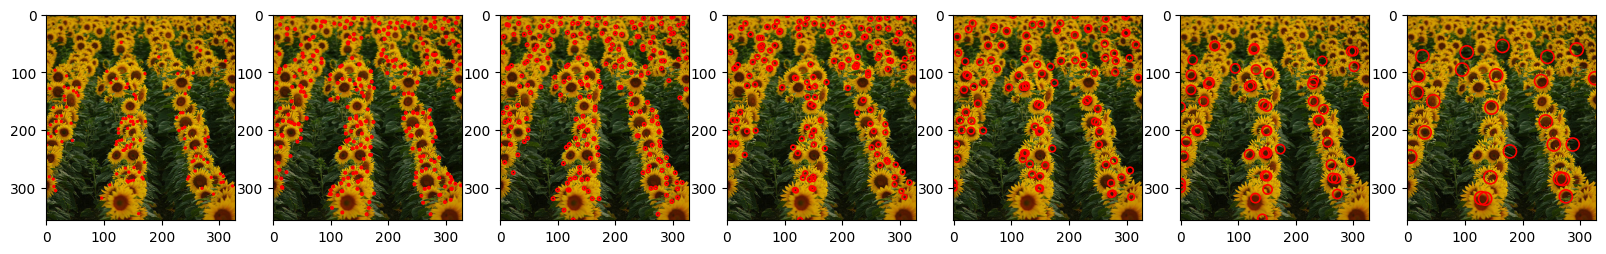

In [138]:
draw_circles_multi(img, coordinates)

In [139]:
# reshaping the array to 1D
# concat the coordinates
coordinates_1d = []

for i in range(len(coordinates)):
    coordinates_1d += coordinates[i]

print(len(coordinates_1d))

978


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

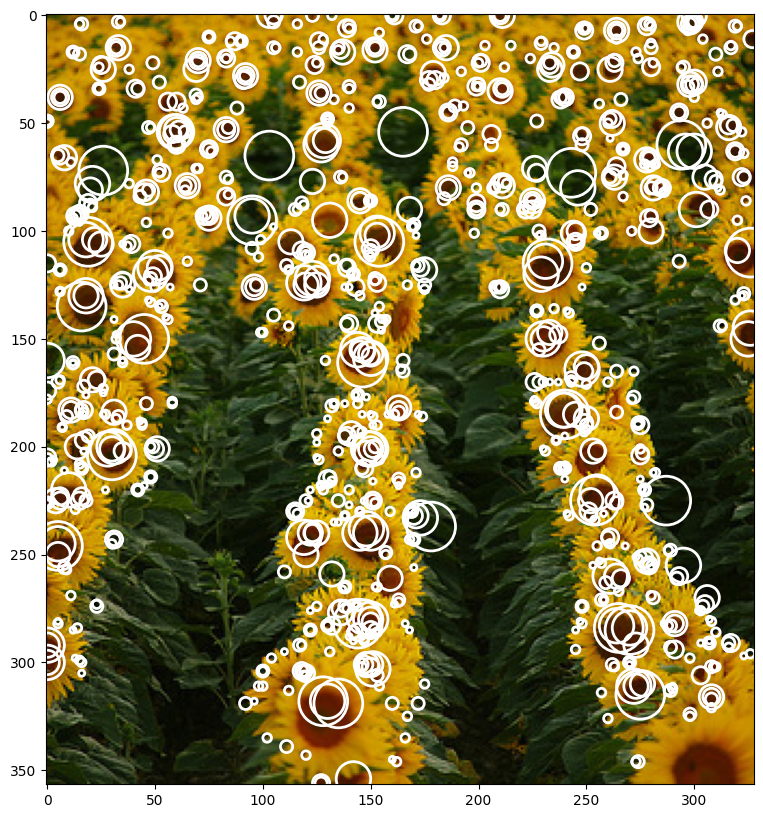

In [140]:
draw_circles(img, coordinates_1d)

In [142]:
res = non_max_suppression(coordinates_1d)


before 978
after 356


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

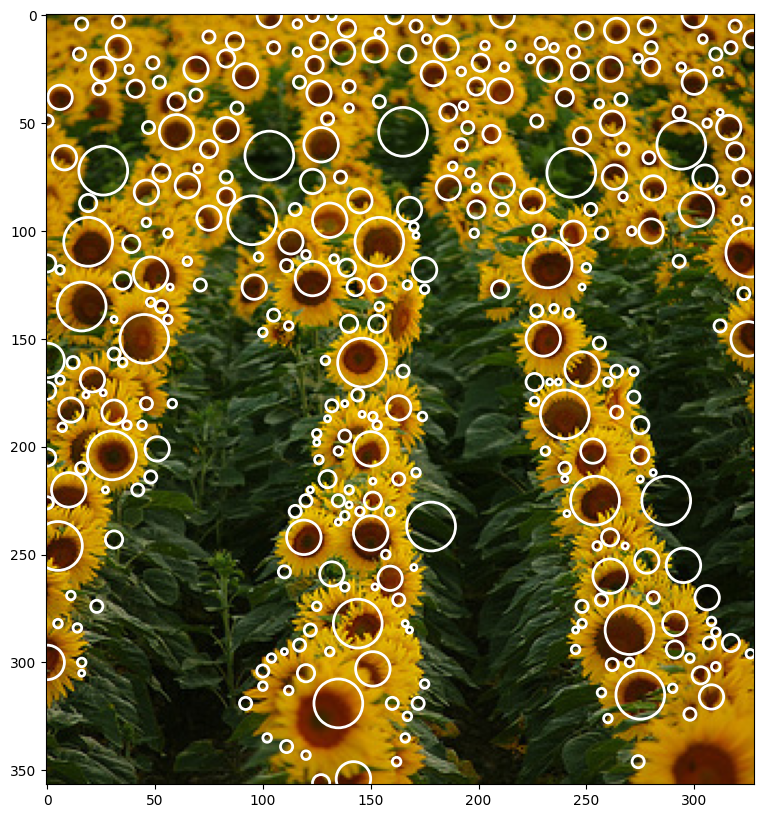

In [143]:
draw_circles(img, res)